<a href="https://colab.research.google.com/github/ianhstudent/ianhHH01/blob/master/Supplementary/NoResamp_ANN%26EarlyStop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
!pip install shap

import io
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.utils import compute_class_weight
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import shap
import matplotlib.pyplot as plt
import seaborn as sns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 7.8 MB/s eta 0:00:00


In [ ]:
from google.colab import files
fn = files.upload()


Saving Term&Preterm_AllSamples_20231117.csv to Term&Preterm_AllSamples_20231117.csv


In [ ]:
# Adjust to read the uploaded file (name should already be provided after the upload)
data = pd.read_csv(io.BytesIO(fn['Term&Preterm_AllSamples_20231117.csv']))

print(data)

     Group  4-Aminohippuric acid  5-Aminopentanamide  \
0        0           8415.820791         6905.938406   
1        0           8256.863739        14832.413540   
2        0           3974.474322         8179.276112   
3        0           3597.318170         7409.747105   
4        0           1230.643149          999.343056   
..     ...                   ...                 ...   
145      1           6060.336998        11573.555520   
146      1           4564.755171         2608.258373   
147      1           1522.630155         1265.233521   
148      1           3227.926086         1788.734921   
149      1           1581.129616         1996.768786   

     5-Hydroxyoctanoylcarnitine (C10:0-OH)  Acetylcarnitine  Acetylcholine  \
0                             542037.60150     18407.927030    66215.74512   
1                             705404.28280     27834.145230    58401.76965   
2                              30561.17816     52804.087550    48312.77590   
3              

In [ ]:
X = data.drop(columns=['Group'])  # All columns except 'Group'
y = data['Group']  # Replace with your target column


In [ ]:
n_features = X.shape[1]
print(n_features)

181


In [ ]:
# Exclude features with over 50% missing values
missing_threshold = 0.5  # 50% threshold
X = X.loc[:, X.isna().mean() <= missing_threshold]

n_features = X.shape[1]
print(n_features)

175


In [ ]:
# Handle missing values in the remaining features using KNN imputation
imputer = KNNImputer(n_neighbors=5)  # You can adjust the number of neighbors as needed
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=X.columns)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Epoch 1/500
4/4 - 1s - loss: 0.7236 - accuracy: 0.6667 - val_loss: 0.6755 - val_accuracy: 0.5333 - 915ms/epoch - 229ms/step
Epoch 2/500
4/4 - 0s - loss: 0.5986 - accuracy: 0.6952 - val_loss: 0.6663 - val_accuracy: 0.5556 - 57ms/epoch - 14ms/step
Epoch 3/500
4/4 - 0s - loss: 0.5267 - accuracy: 0.7714 - val_loss: 0.6525 - val_accuracy: 0.6000 - 48ms/epoch - 12ms/step
Epoch 4/500
4/4 - 0s - loss: 0.4879 - accuracy: 0.8381 - val_loss: 0.6527 - val_accuracy: 0.5778 - 43ms/epoch - 11ms/step
Epoch 5/500
4/4 - 0s - loss: 0.4484 - accuracy: 0.8762 - val_loss: 0.6437 - val_accuracy: 0.6222 - 44ms/epoch - 11ms/step
Epoch 6/500
4/4 - 0s - loss: 0.4102 - accuracy: 0.9143 - val_loss: 0.6431 - val_accuracy: 0.6222 - 40ms/epoch - 10ms/step
Epoch 7/500
4/4 - 0s - loss: 0.3774 - accuracy: 0.9333 - val_loss: 0.6517 - val_accuracy: 0.6222 - 54ms/epoch - 14ms/step
Epoch 8/500
4/4 - 0s - loss: 0.3506 - accuracy: 0.9333 - val_loss: 0.6616 - val_accuracy: 0.6000 - 53ms/epoch - 13ms/step
Epoch 9/500
4/4 - 0s -

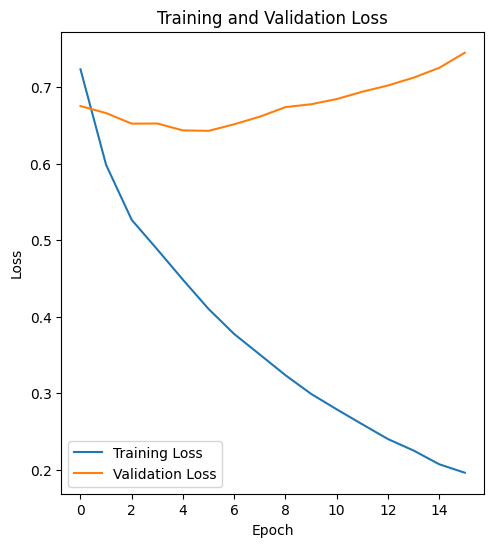

2/2 [==============================] - 0s 8ms/step


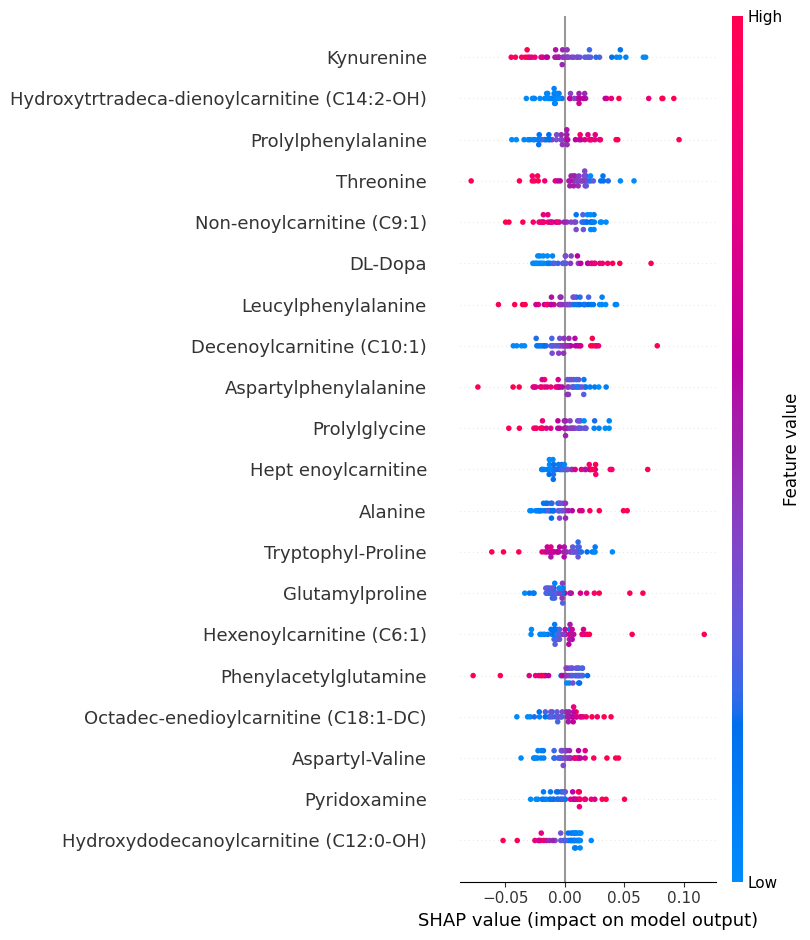

In [ ]:
from tensorflow.keras.optimizers import Adam

# Standardize the input features via Z-score (important for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Create a simple CNN model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_dim=X_train_scaled.shape[1]),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Assuming binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)

# Fit the model with history
history = model.fit(X_train_scaled, y_train, epochs=500, batch_size=32, class_weight={0: class_weights[0], 1: class_weights[1]}, verbose=2, validation_data=(X_test_scaled, y_test), callbacks=[early_stopping])

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

# Make predictions
y_pred_prob = model.predict(X_test_scaled)
y_pred = np.round(y_pred_prob)  # Convert probabilities to binary predictions

# Use SHAP to explain feature importances
explainer = shap.Explainer(model, X_train_scaled)
shap_values = explainer(X_test_scaled)

# Summarize the feature importance values
shap.summary_plot(shap_values, X_test_scaled, feature_names=data.columns)

1/1 [==============================] - 0s 27ms/step - loss: 0.5952 - accuracy: 0.5667
Test Accuracy: 0.57
1/1 [==============================] - 0s 20ms/step
AUC: 0.72


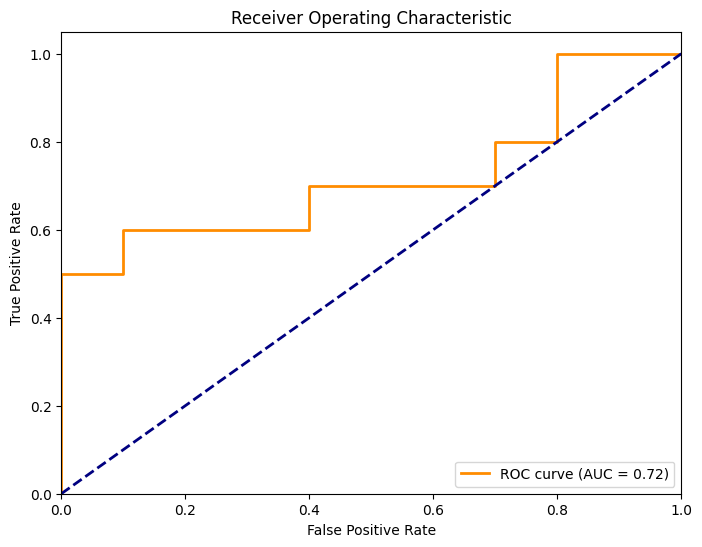

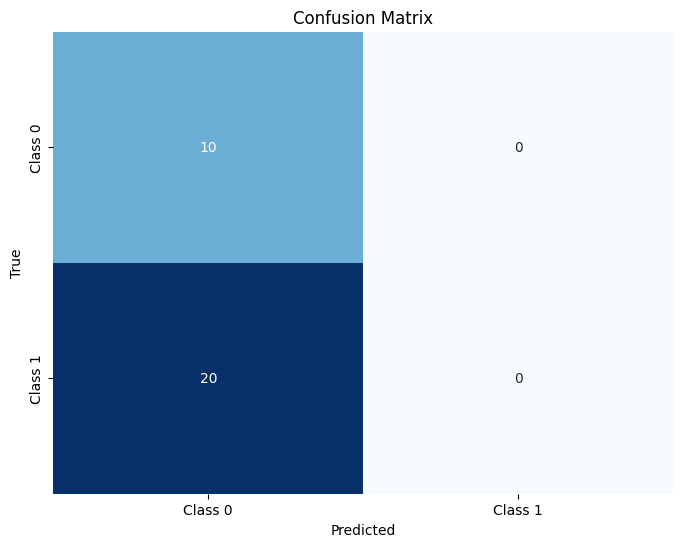

In [ ]:
# Performance Evaluation

# Use the transformed test data directly for evaluation
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Make predictions on the test data
y_pred = model.predict(X_test_scaled)

# Convert predicted probabilities to class labels (0 or 1)
y_pred_binary = np.argmax(y_pred, axis=1)


# Calculate AUC
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.2f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate and plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.show()

In [ ]:
# Check with Cross Validation via KNN
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

# Reshape the data for CNN input (treat it as an image with one channel per feature)
input_shape = (X_train_scaled.shape[1], 1, 1)  # One channel (feature), one pixel
X_train_cnn = X_train_scaled.reshape((-1, *input_shape))
X_test_cnn = X_test_scaled.reshape((-1, *input_shape))

# Extract features from the trained CNN model
cnn_model = keras.Model(inputs=model.input, outputs=model.get_layer('dense_5').output)  # Assuming 'dense_5' is the layer before the final output layer
X_train_features = cnn_model.predict(X_train_scaled)
X_test_features = cnn_model.predict(X_test_scaled)

# Standardize the extracted features
scaler = StandardScaler()
X_train_features_scaled = scaler.fit_transform(X_train_features)
X_test_features_scaled = scaler.transform(X_test_features)

# Create a KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors

# Perform k-fold cross-validation
cv_scores = cross_val_score(knn, X_train_features_scaled, y_train, cv=10)  # 5-fold cross-validation

# Print cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())

# Fit the KNN model on the entire training data
knn.fit(X_train_features_scaled, y_train)

# Evaluate the KNN model on the test data
X_test_features_scaled = scaler.transform(X_test_features)  # Standardize test features
test_accuracy = knn.score(X_test_features_scaled, y_test)
print("Test accuracy:", test_accuracy)

3/3 [==============================] - 0s 15ms/step
Cross-validation scores: [0.75       0.75       0.875      0.75       0.625      0.71428571
 0.85714286 0.85714286 0.71428571 0.85714286]
Mean CV accuracy: 0.775
Test accuracy: 0.6266666666666667
